# Preserve zero and positive values and global maxima with safeguards:
## Example on precipitation from observations and reanalysis

This example explores the effects of applying three different lossy compressors (ZFP, SZ3, SPERR) on a time series (3 days, hourly intervals) of precipitation `PR`. The time series come from observations at Belem, Brazil and Helsinki, Finland, and the corresponding closest grid points in the reanalysis product ERA5. The compressors are applied to either the time series of the individual observations or the global grid of ERA5 (before extracting the observation-space values from the closest grid points). Finally, we apply safeguards to guarantee an absolute error bound and that zero values, positive values, and global extrema are preserved.  

The meteorological relevant properties of precipitation we study are the time and magnitude of the maximum, the integral over the time series, the occurrences of (positive) precipitation (including false positives and negatives), and the occurrences of negative values after compression.

In [1]:
import colorsys
from pathlib import Path

import matplotlib.colors as mc
import matplotlib.dates as mdates
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Retrieve the data
Belem = pd.read_csv(Path() / "data" / "obs-pr" / "belem.csv")
Helsinki = pd.read_csv(Path() / "data" / "obs-pr" / "helsinki.csv")
ERA5 = xr.open_dataset(Path() / "data" / "era5-pr" / "data.nc")

In [3]:
# Extract the data variables
Time = ERA5["valid_time"].data
ERA5_PR = ERA5["tp"] * 1000
Belem_PR = Belem["PR"]
Helsinki_PR = Helsinki["PR"]

In [4]:
ERA5_Belem_PR = ERA5_PR.sel(
    latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
).data
ERA5_Helsinki_PR = ERA5_PR.sel(
    latitude=60.1699, longitude=24.9384, method="nearest"
).data

In [5]:
ERA5_PR.shape, Belem_PR.shape, Helsinki_PR.shape

((72, 721, 1440), (72,), (72,))

In [6]:
def plot_positive_precipitation(pr, ax, y, c, lw=2, bars=False):
    foox = []
    fooy = []
    lastx = None
    wasgap = pr[0] <= 0.0

    for t, p in zip(Time, pr):
        if p > 0.0:
            if wasgap:
                wasgap = False
                foox.append(lastx)
            else:
                foox.append(t)
            fooy.append(y)
        else:
            if not wasgap:
                wasgap = True
                foox.append(lastx)
                fooy.append(y)
                ax.plot(foox, fooy, lw=lw, c=c, solid_capstyle="butt")
                if bars:
                    ax.plot(
                        [foox[0], foox[0]],
                        [fooy[0] - 0.75, fooy[0] + 0.75],
                        lw=lw,
                        c=c,
                        solid_capstyle="butt",
                    )
                    ax.plot(
                        [foox[-1], foox[-1]],
                        [fooy[-1] - 0.75, fooy[-1] + 0.75],
                        lw=lw,
                        c=c,
                        solid_capstyle="butt",
                    )
                foox = []
                fooy = []
        lastx = t

    if len(foox) > 0:
        foox.append(t + (t - lastx))
        fooy.append(y)
        ax.plot(foox, fooy, lw=lw, c=c, solid_capstyle="butt")
        if bars:
            ax.plot(
                [foox[0], foox[0]],
                [fooy[0] - 0.75, fooy[0] + 0.75],
                lw=lw,
                c=c,
                solid_capstyle="butt",
            )
            ax.plot(
                [foox[-1], foox[-1]],
                [fooy[-1] - 0.75, fooy[-1] + 0.75],
                lw=lw,
                c=c,
                solid_capstyle="butt",
            )

In [7]:
def plot_negative_precipitation(pr, ax, y):
    foox = []
    fooy = []
    lastx = None
    wasgap = pr[0] >= 0.0

    for t, p in zip(Time, pr):
        if p < 0.0:
            if wasgap:
                wasgap = False
                foox.append(lastx)
            else:
                foox.append(t)
            fooy.append(y)
        else:
            if not wasgap:
                wasgap = True
                foox.append(lastx)
                fooy.append(y)
                ax.plot(foox, fooy, lw=4, c="red", solid_capstyle="butt")
                foox = []
                fooy = []
        lastx = t

    if len(foox) > 0:
        foox.append(t + (t - lastx))
        fooy.append(y)
        ax.plot(foox, fooy, lw=4, c="red", solid_capstyle="butt")

In [8]:
# based on https://stackoverflow.com/a/49601444
def adjust_color_lightness(color):
    try:
        c = mc.cnames[color]
    except Exception:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))

    if c[1] < 0.5:
        return colorsys.hls_to_rgb(c[0], 0.66, c[2])
    else:
        return colorsys.hls_to_rgb(c[0], 0.33, c[2])

In [9]:
def extract_and_plot(
    ax1,
    ax2,
    my_ERA5_PR: xr.DataArray,
    my_ERA5_PR_cr: float,
    my_Belem_PR: pd.DataFrame,
    my_Belem_PR_cr: float,
    my_Helsinki_PR: pd.DataFrame,
    my_Helsinki_PR_cr: float,
    title: str,
    reference: bool = False,
):
    my_ERA5_Belem_PR = my_ERA5_PR.sel(
        latitude=-1.4563, longitude=360 - 48.5013, method="nearest"
    ).data
    my_ERA5_Helsinki_PR = my_ERA5_PR.sel(
        latitude=60.1699, longitude=24.9384, method="nearest"
    ).data

    ax1.set_title(
        f"{title}\n"
        + rf"$L_{{{{\infty}}}}(\hat{{{{PR_{{{{Hel}}}}}}}})$={np.amax(np.abs(my_Helsinki_PR - Helsinki_PR)):.02}   x {np.round(my_Helsinki_PR_cr, 2)}"
        + "     "
        + rf"$L_{{{{\infty}}}}(\hat{{{{PR_{{{{Bel}}}}}}}})$={np.amax(np.abs(my_Belem_PR - Belem_PR)):.02}   x {np.round(my_Belem_PR_cr, 2)}"
    )
    ax2.set_title(
        "\n"
        + rf"$L_{{{{\infty}}}}(\hat{{{{PR_{{{{ERA5}}}}}}}})$={np.amax(np.abs(my_ERA5_PR - ERA5_PR)):.02}   x {np.round(my_ERA5_PR_cr, 2)}"
    )

    pos = mdates.HourLocator(byhour=(0, 6, 12, 18))
    fmt = mdates.DateFormatter("%d-%m %Hh")

    bf = ax1.fill_between(
        Time,
        my_Belem_PR,
        alpha=0.5,
        step="pre",
        label=f"Integral: {np.format_float_positional(np.sum(Belem_PR), precision=1, min_digits=1)}mm"
        if reference
        else f"Integral: {np.format_float_positional(100 * (np.sum(my_Belem_PR) - np.sum(Belem_PR)) / np.sum(Belem_PR), precision=1, min_digits=1, sign=True)}%",
    )
    hf = ax1.fill_between(
        Time,
        my_Helsinki_PR,
        alpha=0.5,
        step="pre",
        label=f"Integral: {np.format_float_positional(np.sum(Helsinki_PR), precision=1, min_digits=1)}mm"
        if reference
        else f"Integral: {np.format_float_positional(100 * (np.sum(my_Helsinki_PR) - np.sum(Helsinki_PR)) / np.sum(Helsinki_PR), precision=1, min_digits=1, sign=True)}%",
    )

    bp = ax1.plot(Time, my_Belem_PR, ds="steps-pre", ls=(0, (1, 1)))
    hp = ax1.plot(Time, my_Helsinki_PR, ds="steps-pre", ls=(0, (1, 1)))

    ax1.plot(
        Time,
        Belem_PR,
        ds="steps-pre",
        c=adjust_color_lightness(bp[0].get_c()),
        lw=1,
        zorder=-5,
    )
    ax1.plot(
        Time,
        Helsinki_PR,
        ds="steps-pre",
        c=adjust_color_lightness(hp[0].get_c()),
        lw=1,
        zorder=-5,
    )

    ax1.axhline(-1.5, c="black", lw=1)
    ax1.text(
        Time[0] + (Time[-1] - Time[0]) / 2,
        -3.75,
        "time periods with non-zero precipitation:",
        ha="center",
        va="center",
    )

    plot_positive_precipitation(my_Belem_PR, ax1, -7.5, bp[0].get_c(), lw=3)
    plot_negative_precipitation(my_Belem_PR, ax1, -7.5)
    plot_positive_precipitation(my_Helsinki_PR, ax1, -6, hp[0].get_c(), lw=3)
    plot_negative_precipitation(my_Helsinki_PR, ax1, -6)

    plot_positive_precipitation(
        Belem_PR, ax1, -7.5, adjust_color_lightness(bp[0].get_c()), lw=1, bars=True
    )
    plot_positive_precipitation(
        Helsinki_PR, ax1, -6, adjust_color_lightness(hp[0].get_c()), lw=1, bars=True
    )

    bpp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c=bp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.sum(Belem_PR > 0)}h"
        if reference
        else f"PR > 0: {np.format_float_positional(100 * (np.sum(my_Belem_PR > 0) - np.sum(Belem_PR > 0)) / np.sum(Belem_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    bfp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=r" $\hookrightarrow$FN+FP: 0h"
        if reference
        else rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_Belem_PR > 0) != (Belem_PR > 0)), precision=1, min_digits=1)}%",
    )
    bnp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.sum(Belem_PR < 0)}h"
        if reference
        else f"PR < 0: {np.format_float_positional(100 * np.mean(my_Belem_PR < 0), precision=1, min_digits=1)}%",
    )
    hpp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c=hp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.sum(Helsinki_PR > 0)}h"
        if reference
        else f"PR > 0: {np.format_float_positional(100 * (np.sum(my_Helsinki_PR > 0) - np.sum(Helsinki_PR > 0)) / np.sum(Helsinki_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    hfp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=r" $\hookrightarrow$FN+FP: 0h"
        if reference
        else rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_Helsinki_PR > 0) != (Helsinki_PR > 0)), precision=1, min_digits=1)}%",
    )
    hnp = ax1.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.sum(Helsinki_PR < 0)}h"
        if reference
        else f"PR < 0: {np.format_float_positional(100 * np.mean(my_Helsinki_PR < 0), precision=1, min_digits=1)}%",
    )

    bm = ax1.scatter(
        [Time[np.argmax(my_Belem_PR)]],
        [np.amax(my_Belem_PR)],
        marker="o",
        facecolors="none",
        edgecolors=bp[0].get_c(),
        label=f"Max: {np.format_float_positional(np.amax(Belem_PR), precision=2, min_digits=2)}mm"
        if reference
        else f"Max: {np.format_float_positional((Time[np.argmax(my_Belem_PR)] - Time[np.argmax(Belem_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_Belem_PR) - np.amax(Belem_PR), precision=2, min_digits=2, sign=True)}mm",
    )
    hm = ax1.scatter(
        [Time[np.argmax(my_Helsinki_PR)]],
        [np.amax(my_Helsinki_PR)],
        marker="o",
        facecolors="none",
        edgecolors=hp[0].get_c(),
        label=f"Max: {np.format_float_positional(np.amax(Helsinki_PR), precision=2, min_digits=2)}mm"
        if reference
        else f"Max: {np.format_float_positional((Time[np.argmax(my_Helsinki_PR)] - Time[np.argmax(Helsinki_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_Helsinki_PR) - np.amax(Helsinki_PR), precision=2, min_digits=2, sign=True)}mm",
    )

    cax1 = ax1.inset_axes([1.08, 0.0, 0.1, 1.0])
    cax1.hist(
        [my_Helsinki_PR - Helsinki_PR, my_Belem_PR - Belem_PR],
        range=(-0.1, 0.1),
        bins=21,
        orientation="horizontal",
        color=[hp[0].get_c(), bp[0].get_c()],
        histtype="stepfilled",
        alpha=0.5,
    )
    cax1.hist(
        [my_Helsinki_PR - Helsinki_PR, my_Belem_PR - Belem_PR],
        range=(-0.1, 0.1),
        bins=21,
        orientation="horizontal",
        color=[hp[0].get_c(), bp[0].get_c()],
        histtype="step",
    )
    cax1.set_xticks([])
    cax1.set_yticks([-0.1, 0.0, 0.1])
    cax1.set_yticklabels(
        ["$-0.1$", "", "$+0.1$"],
        path_effects=[pe.withStroke(linewidth=3, foreground="w")],
    )
    cax1.yaxis.set_tick_params(length=2, pad=-29)
    cax1.set_ylabel("precipitation error (mm / 1h)")
    cax1.spines[:].set_visible(False)
    cax1.patch.set_alpha(0.0)
    q1, q2, q3 = np.quantile(my_Belem_PR - Belem_PR, [0.25, 0.5, 0.75])
    cax1.axhline(
        (my_Belem_PR - Belem_PR).mean(), ls=":", xmin=0.55, xmax=1.0, c="w", lw=2
    )
    cax1.axhline(q1, xmin=0.55, xmax=1.0, c="w", lw=2)
    cax1.axhline(q2, xmin=0.75, xmax=1.0, c="w", lw=2)
    cax1.axhline(q3, xmin=0.55, xmax=1.0, c="w", lw=2)
    cax1.axhline(
        (my_Belem_PR - Belem_PR).mean(),
        xmin=0.55,
        xmax=1.0,
        ls=":",
        c=bp[0].get_c(),
        lw=1,
    )
    cax1.axhline(q1, xmin=0.55, xmax=1.0, c=bp[0].get_c(), lw=1)
    cax1.axhline(q2, xmin=0.75, xmax=1.0, c=bp[0].get_c(), lw=1)
    cax1.axhline(q3, xmin=0.55, xmax=1.0, c=bp[0].get_c(), lw=1)
    q1, q2, q3 = np.quantile(my_Helsinki_PR - Helsinki_PR, [0.25, 0.5, 0.75])
    cax1.axhline(
        (my_Helsinki_PR - Helsinki_PR).mean(), ls=":", xmin=0.0, xmax=0.45, c="w", lw=2
    )
    cax1.axhline(q1, xmin=0.0, xmax=0.25, c="w", lw=2)
    cax1.axhline(q2, xmin=0.0, xmax=0.45, c="w", lw=2)
    cax1.axhline(q3, xmin=0.0, xmax=0.25, c="w", lw=2)
    cax1.axhline(
        (my_Helsinki_PR - Helsinki_PR).mean(),
        xmin=0.0,
        xmax=0.45,
        ls=":",
        c=hp[0].get_c(),
        lw=1,
    )
    cax1.axhline(q1, xmin=0.0, xmax=0.25, c=hp[0].get_c(), lw=1)
    cax1.axhline(q2, xmin=0.0, xmax=0.45, c=hp[0].get_c(), lw=1)
    cax1.axhline(q3, xmin=0.0, xmax=0.25, c=hp[0].get_c(), lw=1)

    ax1.set_ylabel("precipitation observations (mm / 1h)")
    ax1.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax1.set_xlim(Time.min(), Time.max())
    ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=30, ha="right")
    ax1.set_ylim(-9, 30)
    ax1.set_yticks([0, 5, 10, 15, 20, 25])

    l1 = ax1.legend(
        handles=[hm, hf, *hpp, *hfp, *hnp], loc="upper left", title="Helsinki, Finland"
    )
    ax1.legend(
        handles=[bm, bf, *bpp, *bfp, *bnp], loc="upper right", title="Belem, Brazil"
    )
    ax1.add_artist(l1)

    bf = ax2.fill_between(
        Time,
        my_ERA5_Belem_PR,
        alpha=0.5,
        step="pre",
        label=f"Integral: {np.format_float_positional(np.sum(ERA5_Belem_PR), precision=1, min_digits=1)}mm"
        if reference
        else f"Integral: {np.format_float_positional(100 * (np.sum(my_ERA5_Belem_PR) - np.sum(ERA5_Belem_PR)) / np.sum(ERA5_Belem_PR), precision=1, min_digits=1, sign=True)}%",
    )
    hf = ax2.fill_between(
        Time,
        my_ERA5_Helsinki_PR,
        alpha=0.5,
        step="pre",
        label=f"Integral: {np.format_float_positional(np.sum(ERA5_Helsinki_PR), precision=1, min_digits=1)}mm"
        if reference
        else f"Integral: {np.format_float_positional(100 * (np.sum(my_ERA5_Helsinki_PR) - np.sum(ERA5_Helsinki_PR)) / np.sum(ERA5_Helsinki_PR), precision=1, min_digits=1, sign=True)}%",
    )

    bp = ax2.plot(Time, my_ERA5_Belem_PR, ds="steps-pre", ls=(0, (1, 1)))
    hp = ax2.plot(Time, my_ERA5_Helsinki_PR, ds="steps-pre", ls=(0, (1, 1)))

    ax2.plot(
        Time,
        ERA5_Belem_PR,
        ds="steps-pre",
        c=adjust_color_lightness(bp[0].get_c()),
        lw=1,
        zorder=-5,
    )
    ax2.plot(
        Time,
        ERA5_Helsinki_PR,
        ds="steps-pre",
        c=adjust_color_lightness(hp[0].get_c()),
        lw=1,
        zorder=-5,
    )

    ax2.axhline(-1.5, c="black", lw=1)
    ax2.text(
        Time[0] + (Time[-1] - Time[0]) / 2,
        -3.75,
        "time periods with non-zero precipitation:",
        ha="center",
        va="center",
    )

    plot_positive_precipitation(my_ERA5_Belem_PR, ax2, -7.5, bp[0].get_c())
    plot_negative_precipitation(my_ERA5_Belem_PR, ax2, -7.5)
    plot_positive_precipitation(my_ERA5_Helsinki_PR, ax2, -6, hp[0].get_c())
    plot_negative_precipitation(my_ERA5_Helsinki_PR, ax2, -6)

    plot_positive_precipitation(
        ERA5_Belem_PR, ax2, -7.5, adjust_color_lightness(bp[0].get_c()), lw=1, bars=True
    )
    plot_positive_precipitation(
        ERA5_Helsinki_PR,
        ax2,
        -6,
        adjust_color_lightness(hp[0].get_c()),
        lw=1,
        bars=True,
    )

    bpp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c=bp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.sum(ERA5_Belem_PR > 0)}h"
        if reference
        else f"PR > 0: {np.format_float_positional(100 * (np.sum(my_ERA5_Belem_PR > 0) - np.sum(ERA5_Belem_PR > 0)) / np.sum(ERA5_Belem_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    bfp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=r" $\hookrightarrow$FN+FP: 0h"
        if reference
        else rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_ERA5_Belem_PR > 0) != (ERA5_Belem_PR > 0)), precision=1, min_digits=1)}%",
    )
    bnp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-7.5],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.sum(ERA5_Belem_PR < 0)}h"
        if reference
        else f"PR < 0: {np.format_float_positional(100 * np.mean(my_ERA5_Belem_PR < 0), precision=1, min_digits=1)}%",
    )
    hpp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c=hp[0].get_c(),
        solid_capstyle="butt",
        label=f"PR > 0: {np.sum(ERA5_Helsinki_PR > 0)}h"
        if reference
        else f"PR > 0: {np.format_float_positional(100 * (np.sum(my_ERA5_Helsinki_PR > 0) - np.sum(ERA5_Helsinki_PR > 0)) / np.sum(ERA5_Helsinki_PR > 0), precision=1, min_digits=1, sign=True)}%",
    )
    hfp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=2,
        c="none",
        solid_capstyle="butt",
        label=r" $\hookrightarrow$FN+FP: 0h"
        if reference
        else rf" $\hookrightarrow$FN+FP: {np.format_float_positional(100 * np.mean((my_ERA5_Helsinki_PR > 0) != (ERA5_Helsinki_PR > 0)), precision=1, min_digits=1)}%",
    )
    hnp = ax2.plot(
        [Time[0] - (Time[1] - Time[0])],
        [-6],
        lw=4,
        c="red",
        solid_capstyle="butt",
        label=f"PR < 0: {np.sum(ERA5_Helsinki_PR < 0)}h"
        if reference
        else f"PR < 0: {np.format_float_positional(100 * np.mean(my_ERA5_Helsinki_PR < 0), precision=1, min_digits=1)}%",
    )

    bm = ax2.scatter(
        [Time[np.argmax(my_ERA5_Belem_PR)]],
        [np.amax(my_ERA5_Belem_PR)],
        marker="o",
        facecolors="none",
        edgecolors=bp[0].get_c(),
        label=f"Max: {np.format_float_positional(np.amax(ERA5_Belem_PR), precision=2, min_digits=2)}mm"
        if reference
        else f"Max: {np.format_float_positional((Time[np.argmax(my_ERA5_Belem_PR)] - Time[np.argmax(ERA5_Belem_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_ERA5_Belem_PR) - np.amax(ERA5_Belem_PR), precision=2, min_digits=2, sign=True)}mm",
    )
    hm = ax2.scatter(
        [Time[np.argmax(my_ERA5_Helsinki_PR)]],
        [np.amax(my_ERA5_Helsinki_PR)],
        marker="o",
        facecolors="none",
        edgecolors=hp[0].get_c(),
        label=f"Max: {np.format_float_positional(np.amax(ERA5_Helsinki_PR), precision=2, min_digits=2)}mm"
        if reference
        else f"Max: {np.format_float_positional((Time[np.argmax(my_ERA5_Helsinki_PR)] - Time[np.argmax(ERA5_Helsinki_PR)]) / np.timedelta64(1, 'h'), precision=0, sign=True, trim='-')}h {np.format_float_positional(np.amax(my_ERA5_Helsinki_PR) - np.amax(ERA5_Helsinki_PR), precision=2, min_digits=2, sign=True)}mm",
    )

    cax2 = ax2.inset_axes([1.08, 0.0, 0.1, 1.0])
    cax2.hist(
        [my_ERA5_Helsinki_PR - ERA5_Helsinki_PR, my_ERA5_Belem_PR - ERA5_Belem_PR],
        range=(-0.1, 0.1),
        bins=21,
        orientation="horizontal",
        color=[hp[0].get_c(), bp[0].get_c()],
        histtype="stepfilled",
        alpha=0.5,
    )
    cax2.hist(
        [my_ERA5_Helsinki_PR - ERA5_Helsinki_PR, my_ERA5_Belem_PR - ERA5_Belem_PR],
        range=(-0.1, 0.1),
        bins=21,
        orientation="horizontal",
        color=[hp[0].get_c(), bp[0].get_c()],
        histtype="step",
    )
    cax2.set_xticks([])
    cax2.set_yticks([-0.1, 0.0, 0.1])
    cax2.set_yticklabels(
        ["$-0.1$", "", "$+0.1$"],
        path_effects=[pe.withStroke(linewidth=3, foreground="w")],
    )
    cax2.yaxis.set_tick_params(length=2, pad=-29)
    cax2.set_ylabel("precipitation error (mm / 1h)")
    cax2.spines[:].set_visible(False)
    cax2.patch.set_alpha(0.0)
    q1, q2, q3 = np.quantile(my_ERA5_Belem_PR - ERA5_Belem_PR, [0.25, 0.5, 0.75])
    cax2.axhline(
        (my_ERA5_Belem_PR - ERA5_Belem_PR).mean(),
        ls=":",
        xmin=0.55,
        xmax=1.0,
        c="w",
        lw=2,
    )
    cax2.axhline(q1, xmin=0.75, xmax=1.0, c="w", lw=2)
    cax2.axhline(q2, xmin=0.55, xmax=1.0, c="w", lw=2)
    cax2.axhline(q3, xmin=0.75, xmax=1.0, c="w", lw=2)
    cax2.axhline(
        (my_ERA5_Belem_PR - ERA5_Belem_PR).mean(),
        xmin=0.55,
        xmax=1.0,
        ls=":",
        c=bp[0].get_c(),
        lw=1,
    )
    cax2.axhline(q1, xmin=0.75, xmax=1.0, c=bp[0].get_c(), lw=1)
    cax2.axhline(q2, xmin=0.55, xmax=1.0, c=bp[0].get_c(), lw=1)
    cax2.axhline(q3, xmin=0.75, xmax=1.0, c=bp[0].get_c(), lw=1)
    q1, q2, q3 = np.quantile(my_ERA5_Helsinki_PR - ERA5_Helsinki_PR, [0.25, 0.5, 0.75])
    cax2.axhline(
        (my_ERA5_Helsinki_PR - ERA5_Helsinki_PR).mean(),
        ls=":",
        xmin=0.0,
        xmax=0.45,
        c="w",
        lw=2,
    )
    cax2.axhline(q1, xmin=0.0, xmax=0.25, c="w", lw=2)
    cax2.axhline(q2, xmin=0.0, xmax=0.45, c="w", lw=2)
    cax2.axhline(q3, xmin=0.0, xmax=0.25, c="w", lw=2)
    cax2.axhline(
        (my_ERA5_Helsinki_PR - ERA5_Helsinki_PR).mean(),
        xmin=0.0,
        xmax=0.45,
        ls=":",
        c=hp[0].get_c(),
        lw=1,
    )
    cax2.axhline(q1, xmin=0.0, xmax=0.25, c=hp[0].get_c(), lw=1)
    cax2.axhline(q2, xmin=0.0, xmax=0.45, c=hp[0].get_c(), lw=1)
    cax2.axhline(q3, xmin=0.0, xmax=0.25, c=hp[0].get_c(), lw=1)

    ax2.set_ylabel("ERA5 precipitation (mm / 1h)")
    ax2.xaxis.set(major_locator=pos, major_formatter=fmt)
    ax2.set_xlim(Time.min(), Time.max())
    ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=30, ha="right")
    ax2.set_ylim(-9, 30)
    ax2.set_yticks([0, 5, 10, 15, 20, 25])

    l1 = ax2.legend(
        handles=[hm, hf, *hpp, *hfp, *hnp], loc="upper left", title="Helsinki, Finland"
    )
    ax2.legend(
        handles=[bm, bf, *bpp, *bfp, *bnp], loc="upper right", title="Belem, Brazil"
    )
    ax2.add_artist(l1)

## Compressing precipitation with lossy compressors

We configure each compressor with an absolute error bound of 0.1mm. The observation time series are compressed independently, for ERA5 we compress the entire three day dataset before extracting the observation-space time series.

In [10]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp

In [11]:
def encode_decode(codec):
    ERA5_PR_codec_enc = codec.encode(ERA5_PR.values)
    ERA5_PR_codec = ERA5_PR.copy(data=codec.decode(ERA5_PR_codec_enc))
    ERA5_PR_codec_cr = ERA5_PR.nbytes / ERA5_PR_codec_enc.nbytes

    Belem_PR_codec = Belem_PR.copy(deep=True)
    Belem_PR_codec_enc = codec.encode(Belem_PR_codec.values)
    Belem_PR_codec.values[:] = codec.decode(Belem_PR_codec_enc)
    Belem_PR_codec_cr = Belem_PR.nbytes / Belem_PR_codec_enc.nbytes

    Helsinki_PR_codec = Helsinki_PR.copy(deep=True)
    Helsinki_PR_codec_enc = codec.encode(Helsinki_PR_codec.values)
    Helsinki_PR_codec.values[:] = codec.decode(Helsinki_PR_codec_enc)
    Helsinki_PR_codec_cr = Helsinki_PR.nbytes / Helsinki_PR_codec_enc.nbytes

    return (
        ERA5_PR_codec,
        ERA5_PR_codec_cr,
        Belem_PR_codec,
        Belem_PR_codec_cr,
        Helsinki_PR_codec,
        Helsinki_PR_codec_cr,
    )

In [12]:
eb_abs = 0.1

In [13]:
zfp = Zfp(mode="fixed-accuracy", tolerance=eb_abs)
(
    ERA5_PR_zfp,
    ERA5_PR_zfp_cr,
    Belem_PR_zfp,
    Belem_PR_zfp_cr,
    Helsinki_PR_zfp,
    Helsinki_PR_zfp_cr,
) = encode_decode(zfp)

In [14]:
sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)
(
    ERA5_PR_sz3,
    ERA5_PR_sz3_cr,
    Belem_PR_sz3,
    Belem_PR_sz3_cr,
    Helsinki_PR_sz3,
    Helsinki_PR_sz3_cr,
) = encode_decode(sz3)

In [15]:
sperr = Sperr(mode="pwe", pwe=eb_abs)
(
    ERA5_PR_sperr,
    ERA5_PR_sperr_cr,
    Belem_PR_sperr,
    Belem_PR_sperr_cr,
    Helsinki_PR_sperr,
    Helsinki_PR_sperr_cr,
) = encode_decode(sperr)

## Visual comparison of the decompressed precipitation time series

In the following analyses, we plot the time series of the observed and modelled precipitation in Helsinki, Finland and Belem, Brazil. On each time series, we show the time and magnitude of the maximum as a dot, the filled integral under the curve. Below the time series, we also highlight times at which precipitation occurred, i.e. was positive. Since negative precipitation does not occur but lossy compression can interpolate negative precipitation values, we also highlight time steps with these errors in red.

It is worth noting that the ERA5 time series is more smoothed out than the original observations and includes much longer precipitation events with lower extrema.

All three compressors preserve the global maximum well (only SZ3 changes the time of maxima by one hour for the Helsinki observations) and produce intervals without systematic bias. However, all compressors struggle with preserving zero and positive values as such and with not producing negative values. Since ZFP is a blockwise compressor, it has the least artefacts. SZ3 and SPERR, which are predictive compressors, produce significant negative precipitation values, with SPERR performing worse since its prediction is global.

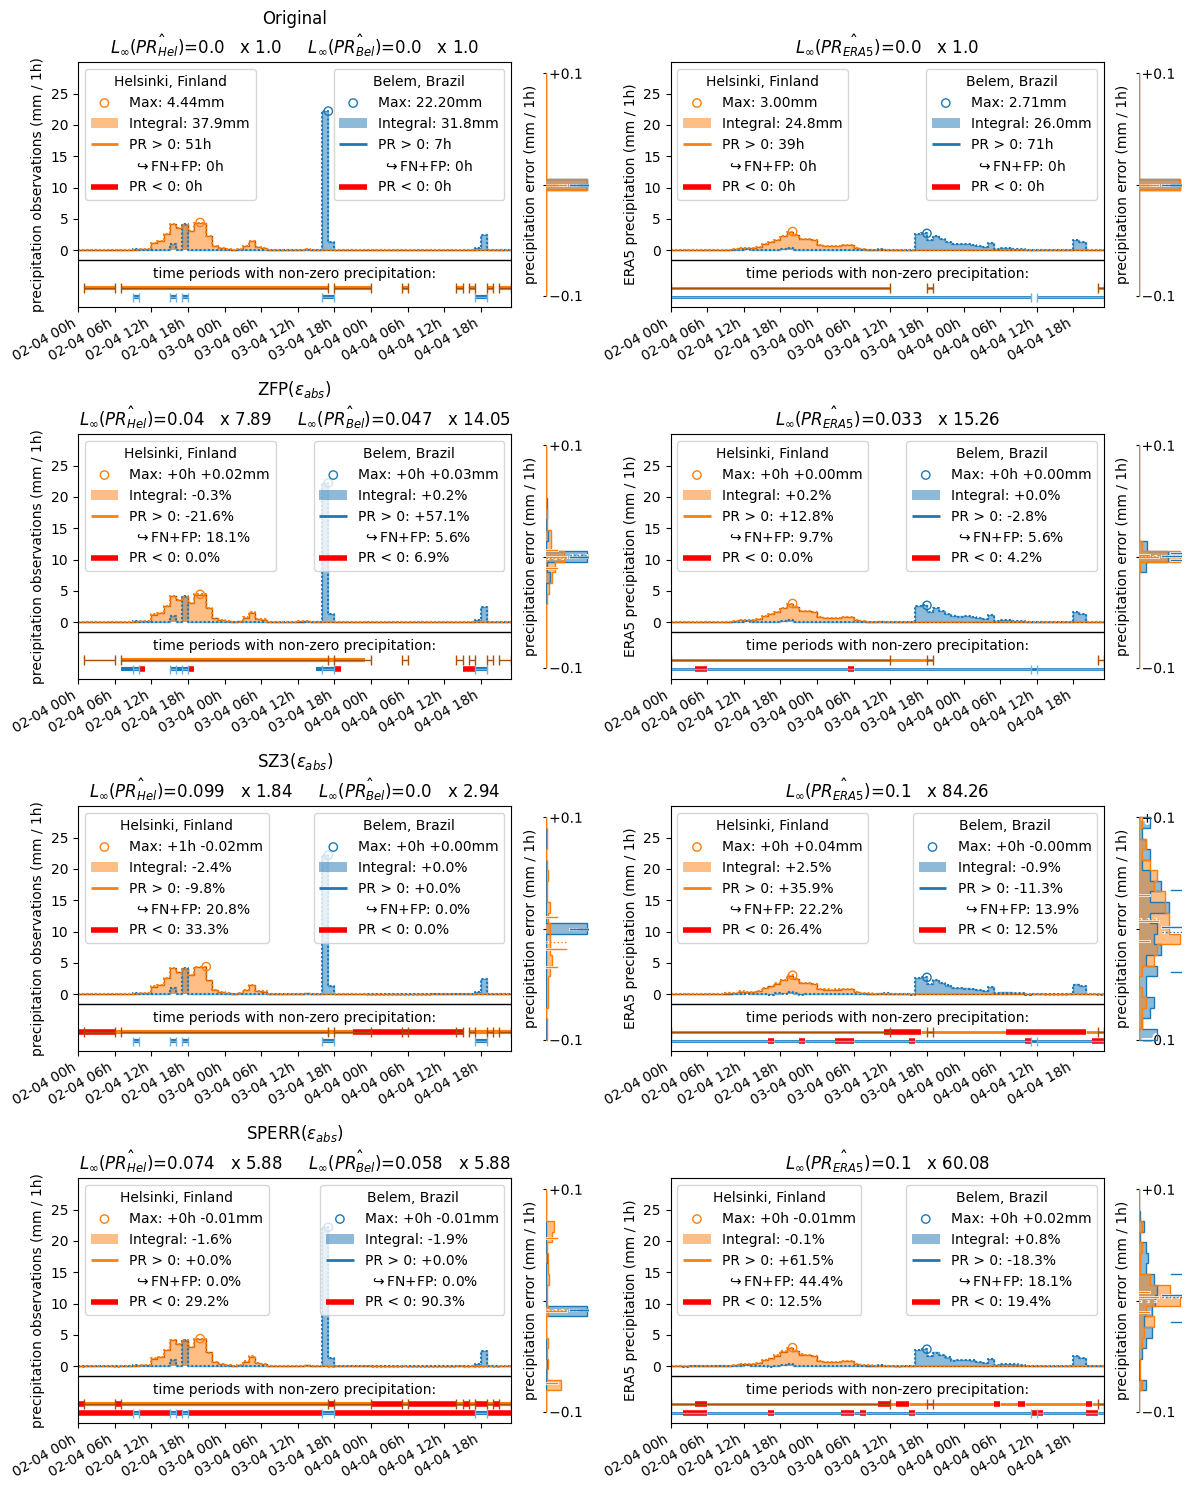

In [16]:
fig, axs = plt.subplots(4, 2, figsize=(12, 15))

extract_and_plot(
    axs[0, 0],
    axs[0, 1],
    ERA5_PR,
    1.0,
    Belem_PR,
    1.0,
    Helsinki_PR,
    1.0,
    "Original",
    reference=True,
)
extract_and_plot(
    axs[1, 0],
    axs[1, 1],
    ERA5_PR_zfp,
    ERA5_PR_zfp_cr,
    Belem_PR_zfp,
    Belem_PR_zfp_cr,
    Helsinki_PR_zfp,
    Helsinki_PR_zfp_cr,
    r"ZFP($\epsilon_{{abs}}$)",
)
extract_and_plot(
    axs[2, 0],
    axs[2, 1],
    ERA5_PR_sz3,
    ERA5_PR_sz3_cr,
    Belem_PR_sz3,
    Belem_PR_sz3_cr,
    Helsinki_PR_sz3,
    Helsinki_PR_sz3_cr,
    r"SZ3($\epsilon_{{abs}}$)",
)
extract_and_plot(
    axs[3, 0],
    axs[3, 1],
    ERA5_PR_sperr,
    ERA5_PR_sperr_cr,
    Belem_PR_sperr,
    Belem_PR_sperr_cr,
    Helsinki_PR_sperr,
    Helsinki_PR_sperr_cr,
    r"SPERR($\epsilon_{{abs}}$)",
)

plt.tight_layout()

plt.savefig("precipitation-codec.pdf")
plt.show()

## Compressing precipitation with the safeguards-wrapped lossy compressors

We configure the safeguards with an absolute error bound of 0.1mm, and to preserve:

- zero and positive values by preserving the sign of the data
- the maximum by preserving the sign relative to the maximum (the maximum retains its exact values, other values cannot exceed it)

For compressing the observation time series, the maximum is the global maximum, which the `numcodecs-safeguards` frontend exposes as the built-in `$x_max` constant. For compressing ERA5, we want to preserve the observed maxima at Helsinki and Belem, so we compute them beforehand and preserve the two maxima separately.

In [17]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [18]:
ERA5_PR_sg = dict()
ERA5_PR_sg_cr = dict()

for codec in [ZeroCodec(), zfp, sz3, sperr]:
    sg_era5 = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs),
            dict(kind="sign"),
            dict(kind="sign", offset=float(np.amax(ERA5_Belem_PR))),
            dict(kind="sign", offset=float(np.amax(ERA5_Helsinki_PR))),
        ],
    )

    ERA5_PR_sg_enc = sg_era5.encode(ERA5_PR.values)
    ERA5_PR_sg[codec.codec_id] = ERA5_PR.copy(data=sg_era5.decode(ERA5_PR_sg_enc))
    ERA5_PR_sg_cr[codec.codec_id] = ERA5_PR.nbytes / np.asarray(ERA5_PR_sg_enc).nbytes

In [19]:
Belem_PR_sg = dict()
Belem_PR_sg_cr = dict()

Helsinki_PR_sg = dict()
Helsinki_PR_sg_cr = dict()

for codec in [ZeroCodec(), zfp, sz3, sperr]:
    sg_obs = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs),
            dict(kind="sign"),
            # we only want to preserve *the* global maximum
            dict(kind="sign", offset="$x_max"),
        ],
    )

    Belem_PR_sg[codec.codec_id] = Belem_PR.copy(deep=True)
    Belem_PR_sg_enc = sg_obs.encode(Belem_PR_sg[codec.codec_id].values)
    Belem_PR_sg[codec.codec_id].values[:] = sg_obs.decode(Belem_PR_sg_enc)
    Belem_PR_sg_cr[codec.codec_id] = (
        Belem_PR.nbytes / np.asarray(Belem_PR_sg_enc).nbytes
    )

    Helsinki_PR_sg[codec.codec_id] = Helsinki_PR.copy(deep=True)
    Helsinki_PR_sg_enc = sg_obs.encode(Helsinki_PR_sg[codec.codec_id].values)
    Helsinki_PR_sg[codec.codec_id].values[:] = sg_obs.decode(Helsinki_PR_sg_enc)
    Helsinki_PR_sg_cr[codec.codec_id] = (
        Helsinki_PR.nbytes / np.asarray(Helsinki_PR_sg_enc).nbytes
    )

## Visual comparison of the safeguarded precipitation time series

The safeguards correctly preserve all properties of interest. However, the total precipitation integral has a consistent negative bias when safeguarding with a constant-zero prediction.

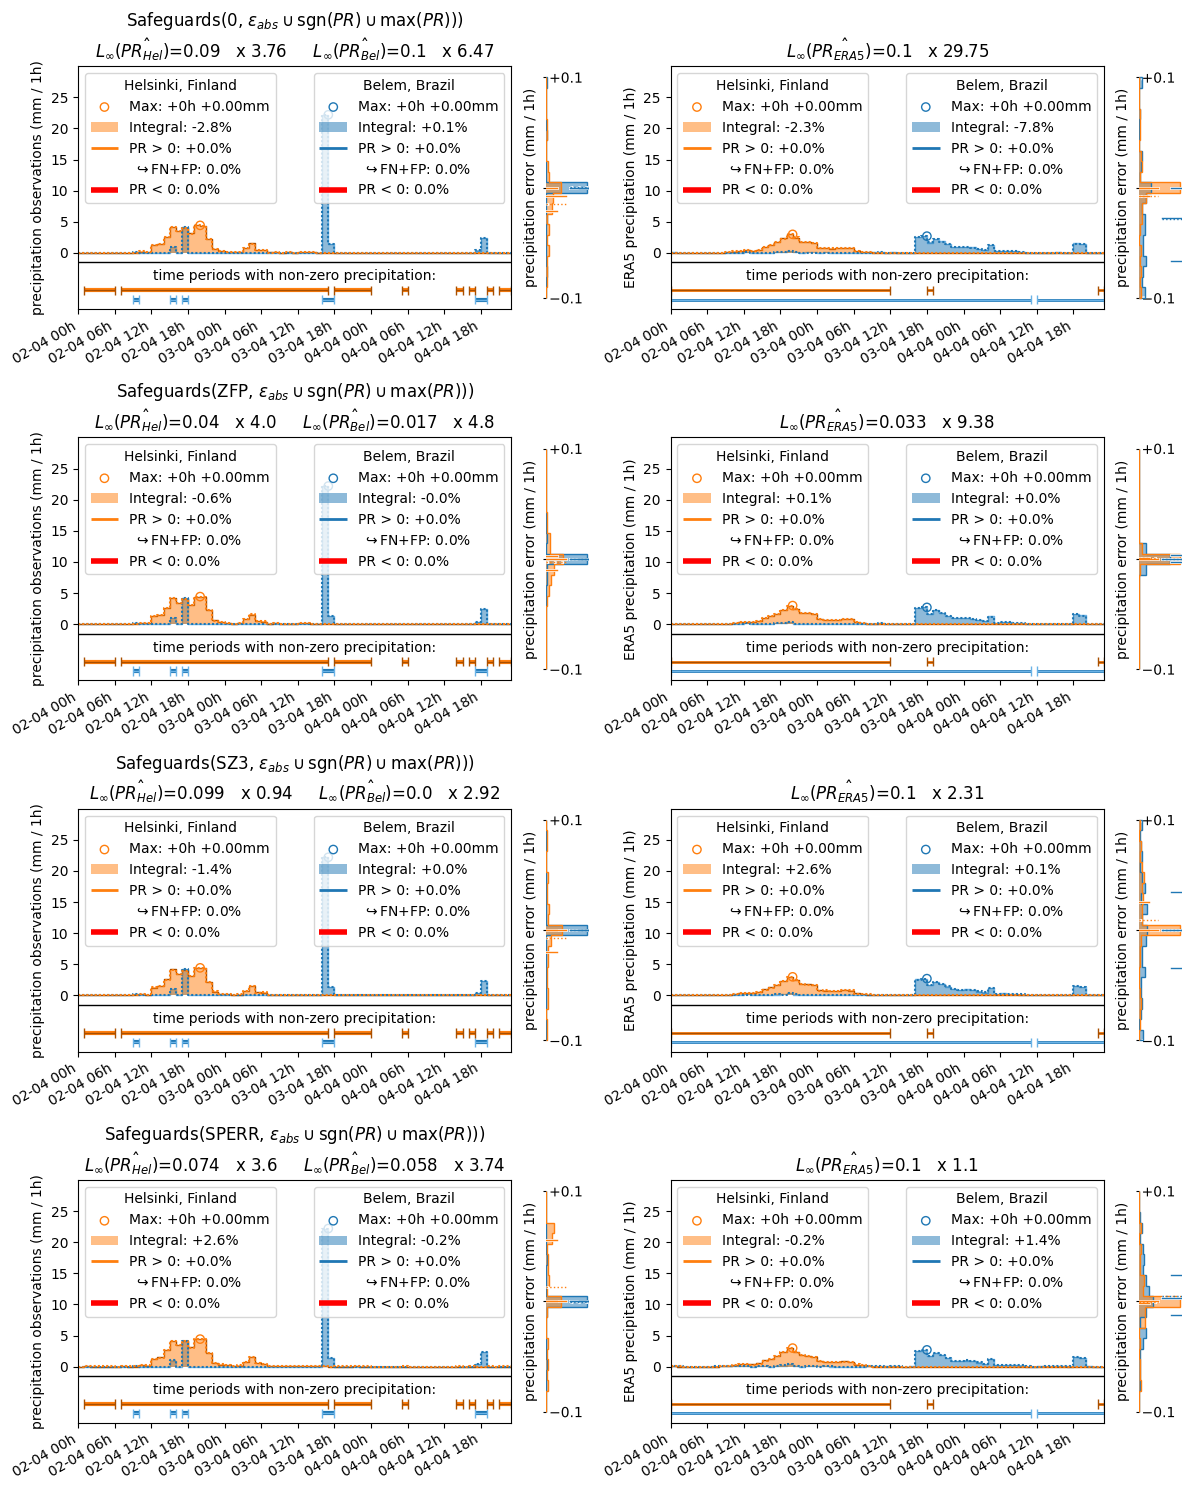

In [20]:
fig, axs = plt.subplots(4, 2, figsize=(12, 15))

extract_and_plot(
    axs[0, 0],
    axs[0, 1],
    ERA5_PR_sg["zero"],
    ERA5_PR_sg_cr["zero"],
    Belem_PR_sg["zero"],
    Belem_PR_sg_cr["zero"],
    Helsinki_PR_sg["zero"],
    Helsinki_PR_sg_cr["zero"],
    r"Safeguards(0, $\epsilon_{{abs}} \cup \text{sgn}(PR) \cup \max(PR))$)",
)

extract_and_plot(
    axs[1, 0],
    axs[1, 1],
    ERA5_PR_sg["zfp.rs"],
    ERA5_PR_sg_cr["zfp.rs"],
    Belem_PR_sg["zfp.rs"],
    Belem_PR_sg_cr["zfp.rs"],
    Helsinki_PR_sg["zfp.rs"],
    Helsinki_PR_sg_cr["zfp.rs"],
    r"Safeguards(ZFP, $\epsilon_{{abs}} \cup \text{sgn}(PR) \cup \max(PR))$)",
)

extract_and_plot(
    axs[2, 0],
    axs[2, 1],
    ERA5_PR_sg["sz3.rs"],
    ERA5_PR_sg_cr["sz3.rs"],
    Belem_PR_sg["sz3.rs"],
    Belem_PR_sg_cr["sz3.rs"],
    Helsinki_PR_sg["sz3.rs"],
    Helsinki_PR_sg_cr["sz3.rs"],
    r"Safeguards(SZ3, $\epsilon_{{abs}} \cup \text{sgn}(PR) \cup \max(PR))$)",
)

extract_and_plot(
    axs[3, 0],
    axs[3, 1],
    ERA5_PR_sg["sperr.rs"],
    ERA5_PR_sg_cr["sperr.rs"],
    Belem_PR_sg["sperr.rs"],
    Belem_PR_sg_cr["sperr.rs"],
    Helsinki_PR_sg["sperr.rs"],
    Helsinki_PR_sg_cr["sperr.rs"],
    r"Safeguards(SPERR, $\epsilon_{{abs}} \cup \text{sgn}(PR) \cup \max(PR))$)",
)

plt.tight_layout()

plt.savefig("precipitation-sg.pdf")
plt.show()